In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import math
import cv2

In [ ]:
np.random.seed(1)

In [ ]:
# parameters = initialize_parameters(2,2,1)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))

In [ ]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)                                                                                                                                                   # To keep random values constant
    parameters = {}
    L = len(layer_dims)                                                                                                                                                    # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 5
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters


In [ ]:
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

def tanh(Z):
    cache = Z
    A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    return A, cache

def ReLU(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def LeakyReLU(Z):
    cache = Z
    A = np.maximum(0.01*Z , Z)
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache 
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def ReLU_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

def tanh_backward(dA, cache):
    Z = cache
    s = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    dZ = dA * (1 - s**2)
    return dZ

def leakyReLU_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z < 0] = 0.01
    return dZ

def out_forward(Z):
    cache = Z
    return Z, cache
  
def out_backward(dA, cache):
    Z = cache
    dZ = dA
    return dZ

In [ ]:
def linear_forward(A, W, b):
    
    Z = np.dot(W,A) + b                                                                                                                                                   #Z = W.A + b
    
    cache = (A, W, b)
    
    return Z, cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):                                                                                      # To apply activtion funtion
    
    if activation == 1:
        Z, linear_cache = linear_forward(A_prev,W,b)                                                                                                 #Z = W.A + b and A, W, b stored in lin_cache
        A, activation_cache = sigmoid(Z)                                                                                                                        # A = af(Z) and Z store in activ_cache
    
    elif activation == 2:
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = tanh(Z)
        
    elif activation == 3:
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = ReLU(Z)
        
    elif activation == 4:
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = LeakyReLU(Z)
        
    elif activation == 0:
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = out_forward(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters, afh, afo):
    
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], afh)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)],parameters['b' + str(L)], afo)
    caches.append(cache)
           
    return AL, caches
    

In [ ]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    A = np.ones((m, 1))
    cost = (1/m)*(np.dot((Y-AL)**2, A.T))
    # cost = -2 * (1-np.dot(AL, AL.T)) * (Y_AL)
    
    cost = np.squeeze(cost)
    cst = sum(cost)
    return cst


In [ ]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * (np.dot(dZ,A_prev.T))
    db = 1 / m * (np.sum(dZ,axis = 1,keepdims = True))
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db


In [ ]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
        
    if activation == 1:
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == 2:
        dZ = tanh_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == 3:
        dZ = ReLU_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == 4:
        dZ = leakyReLU_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == 0:
        dZ = out_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches, afh, afo):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = -2 * (Y-AL)
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = afo)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, activation = afh)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads


In [ ]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW"+ str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db"+ str(l+1)]
        
    return parameters


Mounted at /content/drive
Enter maximum displacement 30


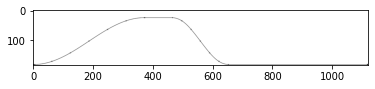

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

img=cv2.imread('/content/drive/MyDrive/Data1.PNG')                                                                                        #Import data

plt.imshow(img,cmap='gray')
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                                                                                                       #Convert image in grayscale and prepare img matrix 
plt.imshow(img,cmap='gray')

pts=[]
xy = []
img.shape

h = int(input("Enter maximum displacement "))

for j in range(img.shape[1]):
  for i in range(img.shape[0]):
    if img[i,j]!=255 and j>10:
      temp=[182-i,j]
      pts.append(182-i)                                                                                                                                                    #‘pts’ array to store value to height 
      xy.append(temp)                                                                                                                                                      #‘xy’ array to store value of cartesian coordinate of black points


max_i = max(pts)                                                                                                                                                           #Maximum value of black point on y axis
le = len(pts)                                                                                                                                                                     #Length of pts array i.e. number of pts on x axis

pts_f=[]

#print(max_i)
for k in pts:                                                                                                                                                                      #Scaling y value to height and storing in 'pts_f' matrix
  k = (k/max_i)*h 
  pts_f.append(k)

for l in xy:                                                                                                                                                                        #Scaling x,y value to 360 degree and height and storing in 'xy' matrix
  l[0] = (l[0]/max_i)*h
  l[1] = (l[1]/j)*360

  
X = np.array([pts_f]).T                                                                                                                                                   #Input matrix
n=le
Y = X

Enter the base circle diiameter in mm: 20
Enter number of hidden layers: 3
Enter number of nodes in a hidden layer: 4
Please Enter which activation function you want to use
Press 1 for Sigmoid
Press 2 for tanh
Press 3 for ReLU
Press 4 for LeakyReLU
Choose activation function for hidden layer:1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


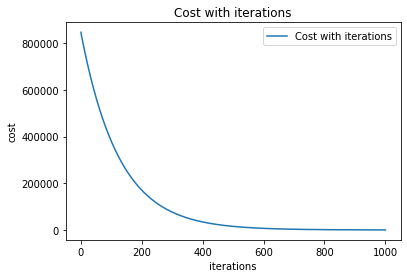

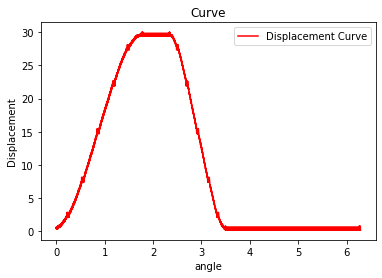

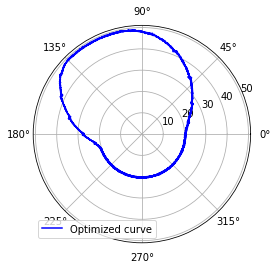

cost = 280.3976862951667


In [ ]:
phi = np.linspace(0, 2*np.pi, n)
Base_circle = int(input("Enter the base circle diiameter in mm: "))                                                                     #Taking input for base circle radius
hid_layer = int(input("Enter number of hidden layers: "))                                                                                     #Taking input for number of hidden layers
nodes = int(input("Enter number of nodes in a hidden layer: "))                                                                         #Taking input for number of nodes


print("Please Enter which activation function you want to use")                                                                         #Taking input for activation function
print("Press 1 for Sigmoid")
print("Press 2 for tanh")
print("Press 3 for ReLU")
print("Press 4 for LeakyReLU")
afh = int(input("Choose activation function for hidden layer:"))
afo = 0

layer_dims = [n]                                                                                                                                                             #Genrating NN structure
for i in range(0, hid_layer):                                                                                                                                          
    layer_dims.append(nodes)
layer_dims.append(n)

parameters = initialize_parameters_deep(layer_dims)                                                                                          #Initialising parameters (W and b)

AL, caches = L_model_forward(X, parameters, afh, afo)                                                                                                                                                  

Al = AL.T
count = []
cost = []                                                                                                                                                                            #Computing cost    
i = 0
iter = 1000

#----------------------------------------------------------------------------------------------------------------------------------------Training
while (iter):                                                                                                                                                                     
    i = i + 1
    count.append(i)
    AL, caches = L_model_forward(X, parameters, afh, afo)                                                                                    #Forward propagation       
    grads = L_model_backward(AL, Y, caches, afh, afo)                                                                                            #Backward propagation
    parameters = update_parameters(parameters, grads, 0.001)                                                                          #Updating parfameter
    cost.append(compute_cost(AL, Y))                                                                                                                          
    iter = iter -1

#----------------------------------------------------------------------------------------------------------------------------------------Plotting cost vs count
x = count
y = cost + 0*count
plt.plot(x,y, label = 'Cost with iterations')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.title('Cost with iterations')
plt.legend()
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------Plotting Cam profile
Xl = np.squeeze(X.T)
Yl = np.squeeze(Y.T)
al = np.squeeze(AL.T)
al = al+ Base_circle
plt.plot(phi, Yl, label ='Displacement Curve', color ='r')
plt.xlabel('angle')
plt.ylabel('Displacement')
plt.title('Curve')
plt.legend()
plt.show()
plt.polar(phi, al, label ='Optimized curve', color = 'b')

plt.legend()
plt.show()

Al = AL.T
print("cost = " + str(compute_cost(AL, Y)))

In [ ]:
ascent_x = []
ascent_y = []
up_x = []
up_y =[]
descent_x = []
descent_y = []
down_x = []
down_y = []

curr = 0
index = 0
hit =0

#----------------------------------------------------------------------------------------------------------------------------------------Classify the points in the ‘xy’ matrix in rise, stay up, fall and stay down categories.
for a in xy:
  #print(a[0])
  if a[0] <= (h-1) and curr == 0:
    ascent_x.append(a[1])                                                                                                                                              #Prepare a separate matrix for the x and y axis.
    ascent_y.append(a[0])

  
  elif a[0]>h-1 and a[0] <= h+1:
    up_x.append(a[1])
    up_y.append(a[0])
    curr = 1
    hit = 1

  elif a[0] < h-1 and a[0] >=1 and  curr == 1 and hit == 0:
    descent_x.append(a[1])
    descent_y.append(a[0])

  elif a[0]<1:
    down_x.append(a[1])
    down_y.append(a[0])

  if len(up_x)>10:
    hit = 0


asc =  len(ascent_x)                                                                                                                                                       #Range of x-axis till the follower rise
up =  len(up_x)                                                                                                                                                               #Range of x-axis till the follower stay up
desc =  len(descent_x)                                                                                                                                                  #Range of x-axis till the follower descends
down = len(down_x)                                                                                                                                                     #Range of x-axis till the follower stay down


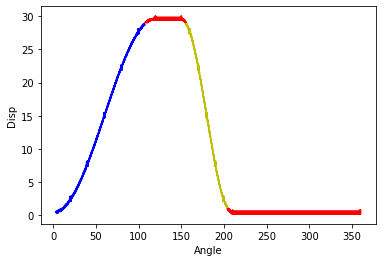

In [ ]:
plt.xlabel("Angle")
plt.ylabel("Disp")
plt.plot(ascent_x, ascent_y, color = 'b')
plt.plot(up_x, up_y, color = 'r')
plt.plot(descent_x, descent_y, color = 'y')
plt.plot(down_x, down_y, color = 'r')

In [ ]:
def poly_reg(x_list, y_list, x_size):
  deg = int(input("Enter degree: "))

#----------------------------------------------------------------------------------------------------------------------------------------Generating left hand side matrix
  rows, cols = (deg+1,deg+1)
  l = []
  sum = 0
  for i in range(cols):
      col = []
      for j in range(rows):
          for k in range(x_size):
              sum = sum + (x_list[k]**(i+j))
          col.append(sum)
          sum=0
      l.append(col)

#----------------------------------------------------------------------------------------------------------------------------------------Generating right hand side matrix
  r = []
  sum = 0
  for i in range(deg+1):
      for j in range(x_size):
          sum = sum + (x_list[j]**i)*y_list[j]
      r.append(sum)
      sum=0
        
  l_inv = np.linalg.inv(l)                                                                                                                                                  # Inverting left hand side matrix
  w = np.dot(l_inv, r)                                                                                                                                                      # Mulipplying inverse LHS matrix with RHS matrix

  x_arr = np.array(x_list)
  y=0                                                                                                                                                                                 # Regressed function
  for i in range(deg+1):
      y=y+(w[i]*(x_arr**(i)))

  plt.plot(x_list, y_list, color = 'b')
  plt.plot(x_arr,y, color = 'r')    
  
  return w, y


Enter degree: 10
Enter degree: 1
Enter degree: 7
Enter degree: 1


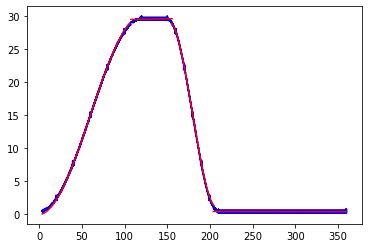

In [ ]:
w_asc=poly_reg(ascent_x,ascent_y, asc)
#print(w_asc)

w_up=poly_reg(up_x,up_y, up)
#print(w_up)

w_desc=poly_reg(descent_x,descent_y, desc)
#print(w_desc)

w_down=poly_reg(down_x,down_y, down)
#print(w_down)